In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import gym
import torch
import torch.nn as nn

from env.p2p_elec_market_3 import TradingSession as TradingSession3
from env.p2p_elec_market_24 import TradingSession as TradingSession24

# Price dynamics:

In [2]:
prices = {}

env = TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus')
env.reset()
done = False

prices[3] = np.array(env.session_prices)

while done == False:
    _, _, done, _ = env.step(0)
    prices[3] = np.vstack([prices[3], env.session_prices])

C:\123\thesis\p2p_DQN\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


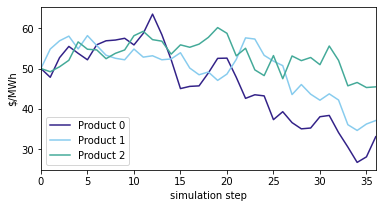

In [3]:
plt.style.use(['C:/Users/lub/.matplotlib/stylelib/muted.mplstyle',              
               'C:/Users/lub/.matplotlib/stylelib/no-latex.mplstyle'])

fig, ax = plt.subplots(1, figsize = [6,3])

ax.plot(prices[3])
ax.set_xlim([0, len(prices[3]) - 1])
ax.set_ylabel('$/MWh')
ax.set_xlabel('simulation step')
ax.legend(['Product 0', 'Product 1', 'Product 2'])
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('prices.pdf', bbox_inches='tight')

# Training curves

In [4]:
sims = ['runs/Jun26_13-46-14_n-62-21-57/reward_100.csv', 
        'runs/Jun26_13-46-42_n-62-21-52/reward_100.csv',
        'runs/Jun26_13-47-49_n-62-21-51/reward_100.csv',
        'runs/Jun26_13-47-14_n-62-21-51/reward_100.csv']

DQN = {}

for sim in sims:
    DQN[sim] = pd.read_csv(sim)

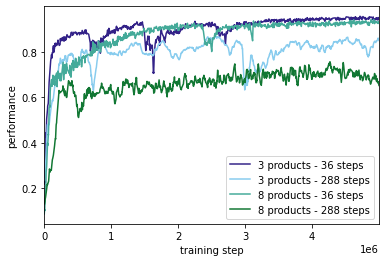

In [5]:
fig, axs = plt.subplots(1)

for i, p in enumerate(sims):
    axs.plot(DQN[p].values[:,1], DQN[p].values[:,2])

axs.set_xlim([0, DQN[p].values[-1,1]])
axs.set_ylabel('performance')
axs.set_xlabel('training step')
axs.legend(['3 products - 36 steps', '3 products - 288 steps','8 products - 36 steps','8 products - 288 steps'])
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('train.pdf',bbox_inches='tight')

# Testing the models

In [6]:
class DQN(nn.Module):
    """Deep Q-network with target network"""

    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        # network
        self.fc = nn.Sequential(
                    nn.Linear(n_inputs, 64),
                    nn.ReLU(),
                    nn.Linear(64, 64),
                    nn.ReLU(),
                    nn.Linear(64, n_outputs)
        )


    def forward(self, x):
        x = x.float()
        return self.fc(x)

In [7]:
class BaselinePolicy:
    """
    Policy that selects action based in current environment state.
    If holdings_quantity does not exceed the boundary, place order with constant value in session with min price.
    If holdings_quantity exceeds the boundary, do not place any order.
    Inputs:
        - current_state: dictionary with current state of the environment
        - constant_order: constant value of the order whem holdings_quantity do not exceed the boundary
        - boundary: boundary of the environment
    """
    def __init__(self, mode, boundary, constant_order=1, action_space_config='discrete'):
        self.constant_order = constant_order
        self.boundary = boundary
        self.mode = mode
        self.action_space_config = action_space_config

    def select_action(self, env):
        self.session_prices = env.session_prices
        self.holdings_quantity = env.holdings_quantity

        if np.sum(self.holdings_quantity) + env.constant_order > self.boundary:
            if self.action_space_config == 'continous':
                action = np.zeros(len(self.holdings_quantity))
                return action
            elif self.action_space_config == 'discrete':
                return np.array([2*len(self.session_prices)])

        else:
            if self.mode == 'min_price':
                idx_min_price = np.argmin(self.session_prices)
                if self.action_space_config == 'continous':
                    action[idx_min_price] = self.constant_order
                    return action
                elif self.action_space_config == 'discrete':
                    return np.array([idx_min_price])

            elif self.mode == 'random':
                idx_random = np.random.randint(0,len(self.session_prices)-1)
                if self.action_space_config == 'continous':
                    action[idx_random] = self.constant_order
                    return action
                elif self.action_space_config == 'discrete':
                    return np.array([idx_random])


# Config and seeds:

In [8]:
num_episodes = 1000
seeds = np.random.randint(num_episodes*2, size=num_episodes)
nums_mutual_sessions = [3]
perf = {}
envs = [TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus'),
        TradingSession24(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus'),
        TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 8, dyn_control = 'minus'),
        TradingSession24(action_space_config = 'discrete', num_mutual_sessions = 8, dyn_control = 'minus')]

sims = ['random-{}'.format(i) for i in range(len(envs))] + ['min_price-{}'.format(i) for i in range(len(envs))] + ['DQN-{}'.format(i) for i in range(len(envs))]
obs_dict = dict.fromkeys(sims)
actions_dict = dict.fromkeys(sims)
returns_dict = dict.fromkeys(sims)
q_values_dict = dict.fromkeys(sims)

C:\123\thesis\p2p_DQN\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Random baseline

In [9]:
mode = 'random'
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs
    policy = BaselinePolicy(mode = mode, boundary = env.boundary, action_space_config = 'discrete')
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            action = policy.select_action(env)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
        policy_reward = np.add.accumulate(rewards)[-1]
        returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], policy_reward])
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("{} performance: {}%". format(mode, round(100*avg_per, 2)))

random performance: 30.79%
random performance: 28.6%
random performance: 12.55%
random performance: 10.36%


# Min price

In [10]:
mode = 'min_price'
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs
    policy = BaselinePolicy(mode = mode, boundary = env.boundary, action_space_config = 'discrete')
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            action = policy.select_action(env)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
        policy_reward = np.add.accumulate(rewards)[-1]
        returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], policy_reward])
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("{} performance: {}%". format(mode, round(100*avg_per, 2)))

min_price performance: 72.89%
min_price performance: 76.49%
min_price performance: 76.02%
min_price performance: 79.09%


# DQN

In [11]:
mode = 'DQN'
model_path = ['runs/Jun26_13-46-14_n-62-21-57/model_3_36.dat',
              'runs/Jun26_13-46-42_n-62-21-52/model_3_288.dat',
              'runs/Jun26_13-47-49_n-62-21-51/model_8_36.dat',
              'runs/Jun26_13-47-14_n-62-21-51/model_8_288.dat']

for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs    
    net = DQN(env.observation_space.shape[0], env.action_space.n)
    net.load_state_dict(torch.load(model_path[i], map_location=lambda storage, loc: storage))
    
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            state_v = torch.tensor(np.array([obs], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            q_values_dict[mode + '-{}'.format(i)] = np.vstack([q_values_dict[mode + '-{}'.format(i)], q_vals.max()])
            action = np.argmax(q_vals)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
            returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], reward])
        policy_reward = np.add.accumulate(rewards)[-1]
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("DQN-{} performance: {}%". format(i, round(100*avg_per, 2)))

DQN-0 performance: 96.67%
DQN-1 performance: 82.47%
DQN-2 performance: 95.14%
DQN-3 performance: 74.77%


# Performances

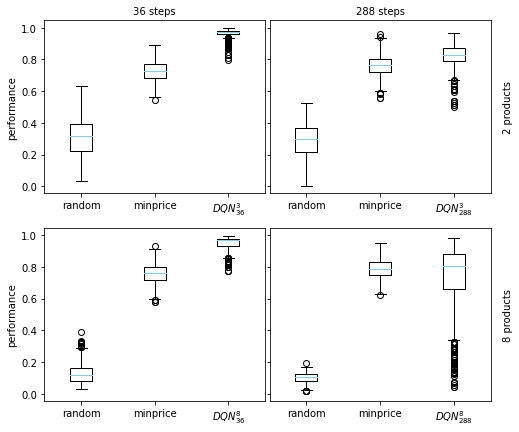

In [12]:
fig, axs = plt.subplots(2, 2, figsize = [8,7], sharey= True)

for i, p in enumerate([0, 1]):
    axs[0,i].boxplot(np.vstack([perf['random-{}'.format(p)], perf['min_price-{}'.format(p)], perf['DQN-{}'.format(p)]]).T)
for i, p in enumerate([2, 3]):
    axs[1,i].boxplot(np.vstack([perf['random-{}'.format(p)], perf['min_price-{}'.format(p)], perf['DQN-{}'.format(p)]]).T)

axs[0,0].set_xticklabels(['random', 'minprice', r'$DQN^{3}_{36}$'])
axs[0,1].set_xticklabels(['random', 'minprice', r'$DQN^{3}_{288}$'])
axs[1,0].set_xticklabels(['random', 'minprice', r'$DQN^{8}_{36}$'])
axs[1,1].set_xticklabels(['random', 'minprice', r'$DQN^{8}_{288}$'])

# Adding axis labels:
axs[0,0].set_ylabel('performance')
axs[1,0].set_ylabel('performance')

axs[0,0].set_title('36 steps', size= 'medium')
axs[0,1].set_title('288 steps', size= 'medium')

axs[0,1].set_ylabel('2 products', size= 'medium')
axs[1,1].set_ylabel('8 products', size= 'medium')
axs[0,1].yaxis.set_label_coords(1.1,0.5)
axs[1,1].yaxis.set_label_coords(1.1,0.5)

plt.subplots_adjust(wspace=0.02, hspace=0.2)
plt.savefig('performance.pdf',bbox_inches='tight')

# Prices analysis

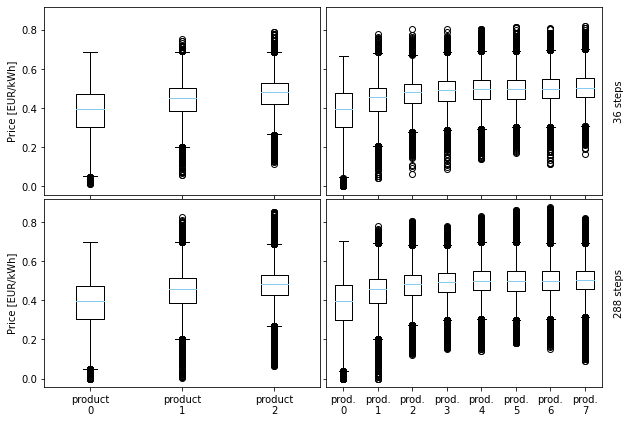

In [13]:
fig, axs = plt.subplots(2, 2, figsize = [10,7], sharey= True)
axs[0,0].boxplot(obs_dict['random-0'][:,0:3])
axs[0,1].boxplot(obs_dict['random-2'][:,0:8])
axs[1,0].boxplot(obs_dict['random-1'][:,0:3])
axs[1,0].set_xticklabels(['product\n{}'.format(n) for n in range(0, 4)])
axs[1,1].boxplot(obs_dict['random-3'][:,0:8])
axs[1,1].set_xticklabels(['prod.\n{}'.format(n) for n in range(0, 8)])

axs[0,0].set_ylabel('Price [EUR/kWh]', size= 'medium')
axs[1,0].set_ylabel('Price [EUR/kWh]', size= 'medium')
axs[0,1].set_ylabel('36 steps', size= 'medium')
axs[1,1].set_ylabel('288 steps', size= 'medium')

axs[0,1].yaxis.set_label_coords(1.08,0.5)
axs[1,1].yaxis.set_label_coords(1.08,0.5)

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('prices.pdf',bbox_inches='tight')

# Q-Value function

In [14]:
fut_return = {}
exp_fut_return = {}
rel_error = {}

for i in range(4):
    if i == 0:
        steps = 36    
    elif i == 1:
        steps = 288
    elif i == 2:
        steps = 36
    elif i == 3:
        steps = 288
    fut_return['DQN-{}'.format(i)] = np.cumsum(returns_dict['DQN-{}'.format(i)][returns_dict['DQN-{}'.format(i)] != np.array(None)].reshape([1000,steps]).T, axis=0)[-1,:] - np.cumsum(returns_dict['DQN-{}'.format(i)][returns_dict['DQN-{}'.format(i)] != np.array(None)].reshape([1000,steps]).T, axis=0)
    exp_fut_return['DQN-{}'.format(i)] = q_values_dict['DQN-{}'.format(i)][q_values_dict['DQN-{}'.format(i)] != np.array(None)].reshape(1000,steps).T

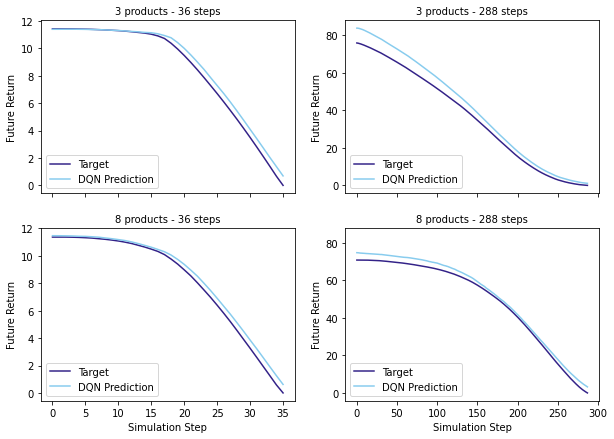

In [15]:
fig, axs = plt.subplots(2, 2, figsize = [10,7], sharey = 'col', sharex = 'col')

axs[0,0].plot(np.mean(fut_return['DQN-0'], axis=1))
axs[0,0].plot(np.mean(exp_fut_return['DQN-0'], axis=1))
axs[0,1].plot(np.mean(fut_return['DQN-1'], axis=1))
axs[0,1].plot(np.mean(exp_fut_return['DQN-1'], axis=1))
axs[1,0].plot(np.mean(fut_return['DQN-2'], axis=1))
axs[1,0].plot(np.mean(exp_fut_return['DQN-2'], axis=1))
axs[1,1].plot(np.mean(fut_return['DQN-3'], axis=1))
axs[1,1].plot(np.mean(exp_fut_return['DQN-3'], axis=1))

axs[0,0].set_title('3 products - 36 steps', size= 'medium')
axs[0,1].set_title('3 products - 288 steps', size= 'medium')
axs[1,0].set_title('8 products - 36 steps', size= 'medium')
axs[1,1].set_title('8 products - 288 steps', size= 'medium')

axs[0,0].set_ylabel('Future Return', size= 'medium')
axs[0,1].set_ylabel('Future Return', size= 'medium')
axs[1,0].set_ylabel('Future Return', size= 'medium')
axs[1,1].set_ylabel('Future Return', size= 'medium')

axs[1,0].set_xlabel('Simulation Step', size= 'medium')
axs[1,1].set_xlabel('Simulation Step', size= 'medium')

axs[0,0].legend(['Target', 'DQN Prediction'], loc = 'lower left')
axs[0,1].legend(['Target', 'DQN Prediction'], loc = 'lower left')
axs[1,0].legend(['Target', 'DQN Prediction'], loc = 'lower left')
axs[1,1].legend(['Target', 'DQN Prediction'], loc = 'lower left')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('predictions.pdf', bbox_inches='tight')


# Visualizing policy

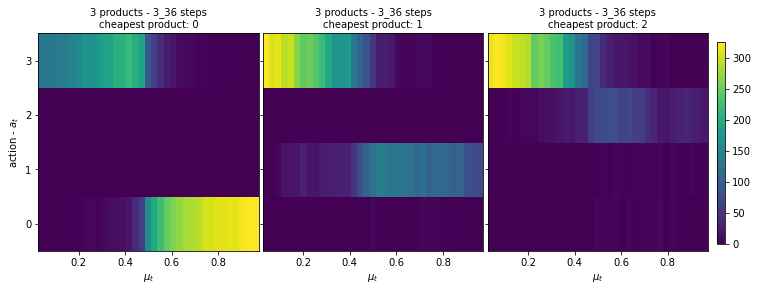

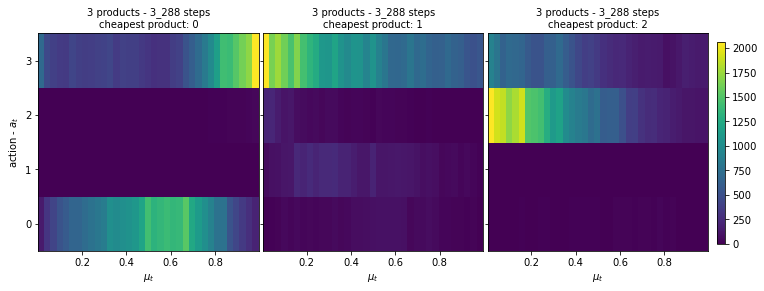

In [16]:
gammas = ['DQN-0', 'DQN-1']
g = ['3_36', '3_288']

for g, gamma in zip(g, gammas):
    policy_df = pd.DataFrame(np.hstack([obs_dict[gamma][1:,:],actions_dict[gamma][1:,:]]))
    p0_df = policy_df[(policy_df.iloc[:,0] < policy_df.iloc[:,1]) & (policy_df.iloc[:,0] < policy_df.iloc[:,2])]
    p1_df = policy_df[(policy_df.iloc[:,1] < policy_df.iloc[:,0]) & (policy_df.iloc[:,1] < policy_df.iloc[:,2])]
    p2_df = policy_df[(policy_df.iloc[:,2] < policy_df.iloc[:,1]) & (policy_df.iloc[:,2] < policy_df.iloc[:,0])]
    
    #Getting data
    x=p0_df.iloc[:,4]
    y=p0_df.iloc[:,5]

    # Creating figure
    fig, axs = plt.subplots(1, 3, figsize =(12, 4), sharey = True, sharex = True)

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    axs[0].hist2d(x, y, bins =[x_bins, y_bins]) 

    axs[0].set_title('3 products - {} steps'.format(g) + '\ncheapest product: 0', size = 'medium')
    axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_xlabel(r'$\mu_t$')
    axs[0].set_ylabel(r'action - $a_t$')
        
    #Getting data
    x=p1_df.iloc[:,4]
    y=p1_df.iloc[:,5]

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    axs[1].hist2d(x, y, bins =[x_bins, y_bins]) 

    axs[1].set_title('3 products - {} steps'.format(g) + '\ncheapest product: 1', size = 'medium')
    axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].set_xlabel(r'$\mu_t$')
    
    #Getting data
    x=p2_df.iloc[:,4]
    y=p2_df.iloc[:,5]

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    h = axs[2].hist2d(x, y, bins =[x_bins, y_bins]) 
    axs[2].set_title('3 products - {} steps'.format(g) + '\ncheapest product: 2', size = 'medium')
    axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[2].set_xlabel(r'$\mu_t$')
    
    cbaxes = fig.add_axes([0.91, 0.15, 0.01, 0.7]) 
    if g == '3_36':
        #cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes, ticks=[0, 165, 331])
        cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes)
    else:
        #cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes, ticks=[0, 995, 1985])
        cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes)
    #cbar.ax.set_yticklabels(['low', 'medium', 'high'])
    
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.savefig('policy_{}.pdf'.format(g), bbox_inches='tight')

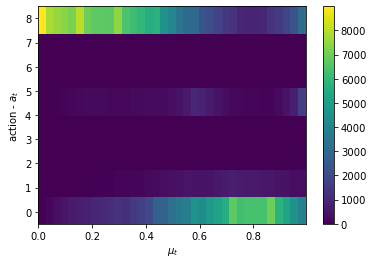

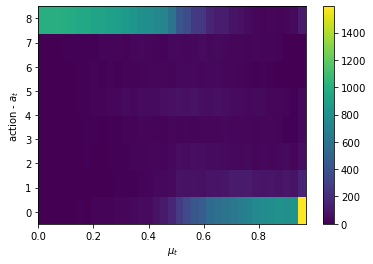

In [17]:
gammas = ['DQN-3', 'DQN-2']
g = ['8_36', '8_288']

for g, gamma in zip(g, gammas):
    policy_df = pd.DataFrame(np.hstack([obs_dict[gamma][1:,:],actions_dict[gamma][1:,:]]))

    # Creating figure
    fig, axs = plt.subplots(1)

    #Getting data
    x=policy_df.iloc[:,9]
    y=policy_df.iloc[:,10]
    
    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36)
    y_bins = np.linspace(-0.5, 8.5, 9)

    # Creating plot 
    h = axs.hist2d(x, y, bins =[x_bins, y_bins]) 

    #axs.set_title('cheapest product: 0', size = 'medium')
    axs.yaxis.set_major_locator(MaxNLocator(integer=True))
    axs.set_xlabel(r'$\mu_t$')
    axs.set_ylabel(r'action - $a_t$')
    
    cbar = fig.colorbar(h[3], ax=axs)
    plt.subplots_adjust(wspace=0.02, hspace=1.2)
    plt.savefig('policy_{}.pdf'.format(g), bbox_inches='tight')